In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

import os
import sys
import skbio
from scipy.stats import pearsonr
from sklearn.metrics import f1_score, mean_squared_error
import matplotlib.patches as mpatches


In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project') # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [5]:
from utils.measures import calculate_f1score, calculate_spearman, calculate_nrmse, inter_dissimilarity, intra_dissimilarity

In [6]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [7]:
sVAR_df = pd.read_csv('svar_pred/donorA_svar1_100otu.csv', index_col = [0])
sVAR_df[sVAR_df<0] = 0
sVAR_df = sVAR_df.iloc[:-1]
true_df = pd.read_csv('/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets/donorA_rarefied_interpolated_feces.csv', index_col = [0])
true_df = true_df[sVAR_df.columns]
history_df = true_df.iloc[-65:-2]

In [8]:
rho_df = calculate_spearman(sVAR_df, history_df, 'rho').dropna().reset_index().rename({'index':'target'}, axis=1)
nrmse_df = calculate_nrmse(sVAR_df, history_df, 'nrmse').dropna().reset_index().rename({'index':'target'}, axis=1)

inter_dissimilarity_df = inter_dissimilarity(history_df, sVAR_df, 'bc')
procrustes_disparity = intra_dissimilarity(history_df, sVAR_df)[-1]

### interactions

<AxesSubplot:>

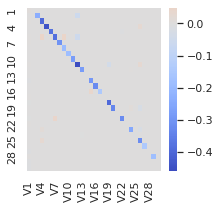

In [20]:
file='interaction_matrices/donorA_100otus_lag10_clr.csv'

interaction_matrix = pd.read_csv(file, index_col = [0])

plt.figure(figsize=[3, 3])
sns.heatmap(interaction_matrix.iloc[:30,:30],  cmap='coolwarm', center=0)

In [32]:
maxlag=10
def read_interaction_matrix(file, lag=maxlag):
    
    '''read interaction matrix created
    by fitting a BigVAR model.'''
    
    interaction_matrix = pd.read_csv(file, index_col = [0])
    interaction_matrix = interaction_matrix.set_index(['otu'])

    #drop intercept
    interaction_matrix = interaction_matrix.drop(['V1'], axis = 1)
    #name columns
    names = [col + "_" + str(i) for i in range(1,lag+1) for col in interaction_matrix.index]
    interaction_matrix.columns = names
    interaction_matrix = interaction_matrix.astype(float)
    
    return interaction_matrix

def make_pairwise_interactions(df, subject=None):
    
    '''create based on interactions matrix
    a df whith columns: 'coeff', 'lag', 
    'interactor','target']'''
    
    interactions_df = []
    for idx in df.index:
        target_df = df.loc[idx]

        try:
        
            interaction_lag_df = pd.DataFrame(target_df).reset_index()
            interaction_lag_df['target'] = target_df.name
            interaction_lag_df.columns = ['interactor', 'coeff', 'target']
            interaction_lag_df[['interactor','lag']] = interaction_lag_df['interactor'].str.split('_',expand=True)
            interactions_df.append(interaction_lag_df)
        except:
            pass
    interactions_df=pd.concat(interactions_df)
    #remove 0 coeffs
    interactions_df = interactions_df[interactions_df['coeff'] !=0]
    
    if subject==None:
        pass
    else:
        
        interactions_df['subject'] = subject
        
    interactions_df= interactions_df.reset_index().drop(['index'], axis=1)
    interactions_df['abs_coeff'] = np.abs(interactions_df['coeff'])
    
    return interactions_df

def filter_interactions_above_treshold(interaction_df, treshold):
        
    filtered_df = interaction_df[(interaction_df['abs_coeff'] > treshold)].reset_index().drop(['index'], axis=1)
    filtered_df['n'] = filtered_df.index
    
    return filtered_df

def find_autocorr(df):
    
    autoregression_df =[]
    for t in df['target'].unique():
        autoreg = df[(df['interactor'] == t) & (df['target'] == t)]
        autoregression_df.append(autoreg)
    autoregression_df = pd.concat(autoregression_df)
    
    return autoregression_df

def calculate_autoregressive_idx(df, subject=None):
    
    #df = df[df['subject'] == subject]

    AUTO_IDX=[]
    COL = []
    for target in df['target'].unique():

        target_df = df[df['target'] == target]
        divider = target_df['abs_coeff'].sum()
        auto = target_df[target_df['interaction'] == 'autogressive']['abs_coeff'].sum()

        autoregressive_idx = auto/divider
        AUTO_IDX.append(autoregressive_idx)
        COL.append(target)

    autoreg_idx_df = pd.DataFrame(list(zip(COL, AUTO_IDX)), columns = ['target', 'autoregression_idx'])
    
    
    return autoreg_idx_df

In [22]:
interactions_df = make_pairwise_interactions(read_interaction_matrix(file))

interactions_df['abs_coeff'] = np.abs(interactions_df['coeff'])
treshold = (interactions_df['abs_coeff']).quantile(.1)

interactions_df['idx'] = interactions_df.index
interactions_df = filter_interactions_above_treshold(interactions_df, treshold)
autoregression_df = find_autocorr(interactions_df)

auto_idx = autoregression_df['idx']
interactions_df['interaction'] = np.where(interactions_df['idx'].isin(auto_idx), 'autogressive', 'non-autogressive')

autoreg_idx = calculate_autoregressive_idx(interactions_df)
autoregression_df = pd.merge(autoregression_df, autoreg_idx, on = 'target')

### 1. number of interactions vs. nrmse

In [23]:
number_of_interactions = pd.DataFrame(interactions_df.groupby(['target']).size(), columns = ['n_interactions'])
number_of_interactions_df = pd.merge(nrmse_df, number_of_interactions, on='target')

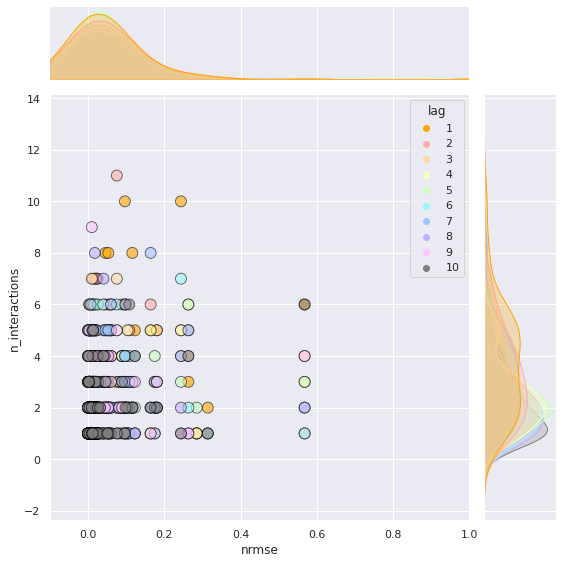

In [34]:
def n_interactions_vs_nrmse(df, lag):
    
    df['lag'] = df['lag'].astype(int)
    mean = []
    col = []

    lag_interactions_df = interactions_df[interactions_df['lag'] == lag]
    for t in lag_interactions_df['target'].unique():
        df = lag_interactions_df[lag_interactions_df['target'] == t]
        n_interactions = df['abs_coeff'].shape[0]
        mean.append(n_interactions)
        col.append(t)

    n_interactions_df = pd.DataFrame(list(zip(col, mean)), columns = ['target', 'n_interactions'])
    n_interactions_df = pd.merge(nrmse_df, n_interactions_df, on='target')
    n_interactions_df['lag'] = lag
    
    return n_interactions_df

coeff_n_df = []
for i in range(1, maxlag+1):
    
    a = n_interactions_vs_nrmse(interactions_df, i)
    coeff_n_df.append(a)
    
coeff_n_df = pd.concat(coeff_n_df).reset_index()

kwrargs = {'s':120, 'alpha':.6, 'edgecolor':'black', 'color':'orange'}
c = ['orange', '#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF', '#9BF6FF', 
     '#A0C4FF', '#BDB2FF', '#FFC6FF', 'grey']

sns.jointplot(data = coeff_n_df,
              y = 'n_interactions',
              x = 'nrmse',
              hue = 'lag',
              palette = c,
              height = 8,
              xlim=-.1,
              **kwrargs)
plt.savefig('plots/coeff_n_nrmse.png')

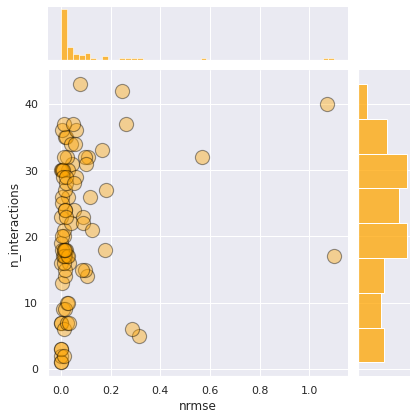

In [37]:
kwrargs = {'s':200, 'alpha':.4, 'edgecolor':'black', 'color':'orange'}
sns.jointplot(data = number_of_interactions_df,
                y = 'n_interactions',
                x = 'nrmse', 
               **kwrargs)

### 2. strength of interactions vs nrmse

In [16]:
mean = []
col = []
for t in interactions_df['target'].unique():
    df = interactions_df[interactions_df['target'] == t]
    mean_coeff = df['abs_coeff'].median()
    mean.append(mean_coeff)
    col.append(t)

coeff_strength = pd.DataFrame(list(zip(col, mean)), columns = ['target', 'mean_coeff'])
coeff_strength_df = pd.merge(nrmse_df, coeff_strength, on='target')

In [65]:
def plot_strength_vs_nrmse(df, lag):
    
    df['lag'] = df['lag'].astype(int)
    mean = []
    col = []

    lag1_interactions_df = df[df['lag'] == lag]
    for t in lag1_interactions_df['target'].unique():
        df = lag1_interactions_df[lag1_interactions_df['target'] == t]
        mean_coeff = df['abs_coeff'].median()
        mean.append(mean_coeff)
        col.append(t)

    coeff_strength = pd.DataFrame(list(zip(col, mean)), columns = ['target', 'mean_coeff'])
    coeff_strength_df = pd.merge(nrmse_df, coeff_strength, on='target')
    coeff_strength_df['lag'] = lag
    
    return coeff_strength_df

coeff_strength_df = []
for i in range(1, 11):
    
    a = plot_strength_vs_nrmse(interactions_df, i)
    coeff_strength_df.append(a)
    
coeff_strength_df = pd.concat(coeff_strength_df).reset_index()

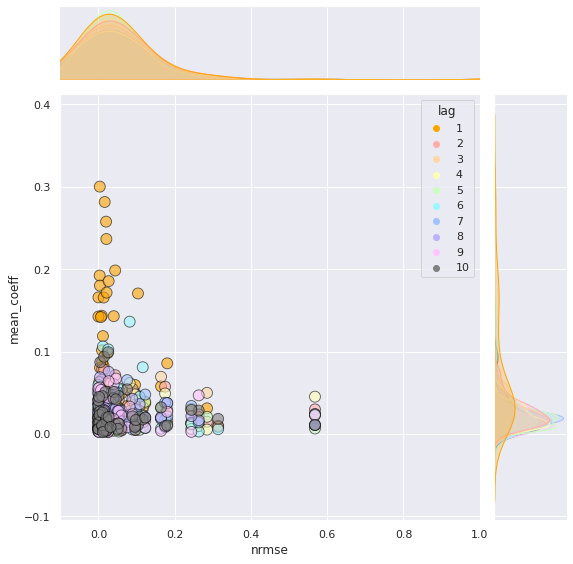

In [69]:
kwrargs = {'s':120, 'alpha':.6, 'edgecolor':'black', 'color':'orange'}
c = ['orange', '#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF', '#9BF6FF', 
     '#A0C4FF', '#BDB2FF', '#FFC6FF', 'grey']

sns.jointplot(data = coeff_strength_df,
              y = 'mean_coeff',
              x = 'nrmse',
              hue = 'lag',
              palette = c,
              height = 8,
              xlim=-.1,
              **kwrargs)
plt.savefig('plots/coeff_strength_nrmse.png')

### 3. long/short term interaction vs error

In [53]:
short = [i for i in range(1, 6)]
long = [i for i in range(6, 11)]
d = interactions_df[interactions_df['interaction'] == 'non-autogressive']

col = []
interaction = []
    
for t in d['target'].unique():
    
    a = d[d['target'] == t]
    b = pd.DataFrame(a.groupby(['target', 'lag', 'abs_coeff']).size(), columns = ['n']).reset_index()
    b['lag'] = b['lag'].astype(int)
    lag12 = b[b['lag'].isin(short)]['abs_coeff'].mean()
    lag35 = b[b['lag'].isin(long)]['abs_coeff'].mean()
    
    
    if lag12 > lag35:
        col.append(t)
        interaction.append('short')
    if lag12 < lag35:
        col.append(t)
        interaction.append('long')

interaction_interval = pd.DataFrame(list(zip(col, interaction)), columns=['target', 'n_interactions'])
interaction_interval_df = pd.merge(nrmse_df, interaction_interval, on='target')
interaction_interval_df_rho = pd.merge(rho_df, interaction_interval, on='target')

<AxesSubplot:xlabel='n_interactions', ylabel='nrmse'>

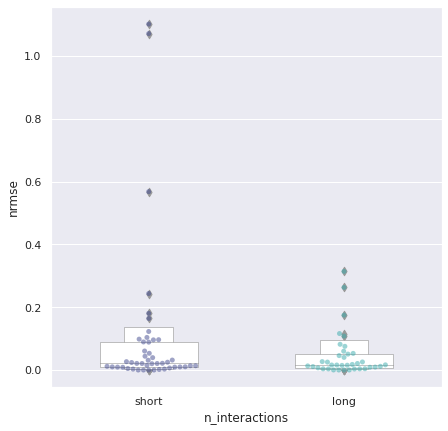

In [61]:
plt.figure(figsize = [7, 7])
sns.boxenplot(data = interaction_interval_df, y = 'nrmse', x='n_interactions', color = 'white', width = .5, linewidth = .6)
sns.swarmplot(data = interaction_interval_df, y = 'nrmse', x='n_interactions', s = 5, alpha=.5, edgecolor='black',  palette = 'mako')

### non-linear interactions

In [94]:
import keras.backend as K
import tensorflow as tf 
from tensorflow.keras import losses
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils.transformers import CLRTransformer

In [99]:
#split to train and test
x_train = true_df.iloc[:300]
x_test = true_df.iloc[301:]

#step 1 - CLR
clr_transformer = CLRTransformer(axis=0)
x_train_clr = clr_transformer.fit_transform(x_train)
x_test_clr = clr_transformer.transform(x_test)

#step 2 - StandardScaler

scaler = StandardScaler()
x_train_clr_scaled = scaler.fit_transform(x_train_clr)
x_test_clr_scaled = scaler.transform(x_test_clr)

In [103]:
class LossBrayCurtis(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        #y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        #y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        #y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value
    
def history_to_df(results):
    
    results_df = pd.DataFrame.from_dict(results.history)
    results_df.columns = ['loss', 'val_loss']
    results_df['epoch'] = results_df.index
    
    return results_df

def plot_history(results_df):
    
    sns.lineplot(x = results_df['epoch'], y = results_df['loss'], color = 'black')
    sns.lineplot(x = results_df['epoch'], y = results_df['val_loss'], color = 'orange', linestyle = '--')
    
    b = mpatches.Patch(color='black', label='train')
    o = mpatches.Patch(color='orange', label='test')

    plt.legend(handles=[b, o], shadow = False)

    plt.show()

In [128]:
def keras_svar_model(l1, l2, normalized_train, normalized_test):
    
    l1 = l1
    l2 = l2
    input_size = normalized_train.shape[1]
    input_data = tf.keras.Input(shape=(input_size,))
    #svar
    svar_layer = tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))
    svar_pred = svar_layer(input_data)
    
    svar_layer = tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))
    svar_pred = svar_layer(svar_pred)
    
    
    #output
    output = tf.keras.layers.Dense(input_size)(svar_pred)
    #model
    svar_model = tf.keras.Model(input_data, output)
    BrayCurtisLoss = LossBrayCurtis(None, None)
    svar_model.compile(
        loss = BrayCurtisLoss,
        optimizer='Adam'
    )
    svar_model.run_eagerly = True

    #train
    svar_model_result = svar_model.fit(normalized_train[:-1], normalized_train[1:],
                                       epochs=40,
                                       batch_size=16,
                                       shuffle=False,
                                       validation_data=(normalized_test[:-1], normalized_test[1:]),
                                       verbose = 0
    )
    
    return svar_model, svar_model_result

In [130]:
model_0001, _ = keras_svar_model(1e-4, 1e-4, x_train_clr, x_test_clr)

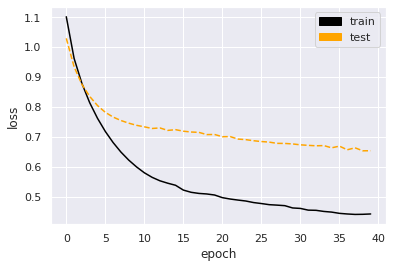

In [131]:
plot_history(history_to_df(_))

In [132]:
pred_0001 = model_0001.predict(normalized_test)
pred_denorm_0001 = scaler.inverse_transform(pred_0001)
pred_denorm__0001_df = pd.DataFrame(pred_denorm_0001, columns = true_df.columns)
pred_denorm__0001_df[pred_denorm__0001_df<0] = 0

In [138]:
pred_denorm__0001_df

,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCGGCAGAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGC,TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGTGGTTTATTAAGTCTGGTGTAAAAGGCAGTGGCTCAACCATTGTATGC,TACGTAGGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGC,TACGTAGGGAGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCTAGGCAAGTCAGACGTGAAAACCATGGGCTCAACCTGTGGACTG,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGCGCGCAGGTGGTTGATTAAGTCTGATGTGAAAGCCCACGGCTTAACCGTGGAGGGG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCACTGCAAGTCTGAAGTGAAAGCCCGGGGCTCAACCCCGGGACTG,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGGGCAAGTCTGATGTGAAAACCCGGGGCTCAACCCCGGGACTG,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGAAGGCAAGTCAGATGTGAAATCCACGGGCTCAACTCGTGAACTG,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCTGGAGCTG,TACGTATGTCCCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGCGCAGACGGTTGATTAAGTCTGATGTGAAAGCCCGGAGCTCAACTCCGGAATGG,...,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGACCGGCAAGTTGGAAGTGAAAACTATGGGCTCAACCCATAAATTG,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGTGGATTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,TACGTAGGGGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGTGCGTAGGTGGTATGGCAAGTCAGAAGTGAAAACCCAGGGCTTAACTCTGGGACTG,TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCACTAAGGGTCTGTGGTGAAAGATCGAAGCTTAACTTCGGTAAGC,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGAACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTG
0,0.619488,0.0,0.451826,0.449348,0.0,0.410066,0.0,0.445693,0.772278,0.501734,...,0.255156,0.417240,0.175756,0.140159,0.045370,0.000221,0.039963,0.000000,0.0,0.480871
1,0.835225,0.0,0.564869,0.474198,0.0,0.545753,0.0,0.314827,1.057892,0.555809,...,0.200982,0.633155,0.183551,0.110601,0.075284,0.017798,0.008506,0.000000,0.0,0.532737
2,0.530312,0.0,0.517884,0.441242,0.0,0.308108,0.0,0.397618,1.091735,0.469648,...,0.196815,0.633531,0.152778,0.093493,0.069318,0.000000,0.003203,0.000000,0.0,0.376052
3,0.155676,0.0,0.487713,0.364802,0.0,0.174414,0.0,0.320891,1.052130,0.403165,...,0.173670,0.619307,0.172977,0.028599,0.069480,0.000000,0.016297,0.000000,0.0,0.399354
4,0.471260,0.0,0.492662,0.415048,0.0,0.373877,0.0,0.229942,0.892475,0.444232,...,0.156507,0.466131,0.194945,0.116581,0.065984,0.000000,0.030378,0.000000,0.0,0.504423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.847554,0.0,0.656659,0.383550,0.0,0.405189,0.0,0.311003,1.011952,0.658184,...,0.364606,0.629205,0.192459,0.129527,0.117824,0.025583,0.030906,0.007071,0.0,0.669367
60,0.877406,0.0,0.621444,0.329354,0.0,0.333834,0.0,0.292711,1.064327,0.613231,...,0.364117,0.613000,0.178141,0.116091,0.108019,0.019741,0.034546,0.020116,0.0,0.616257
61,0.908064,0.0,0.592668,0.321615,0.0,0.385941,0.0,0.292316,1.016725,0.605306,...,0.351451,0.599454,0.170668,0.129450,0.099007,0.018535,0.024746,0.024989,0.0,0.606554
62,0.795819,0.0,0.746031,0.499574,0.0,0.456090,0.0,0.387604,1.244854,0.686569,...,0.299365,0.776093,0.186129,0.082517,0.139918,0.034668,0.008185,0.000000,0.0,0.623456


Text(0, 0.5, '')

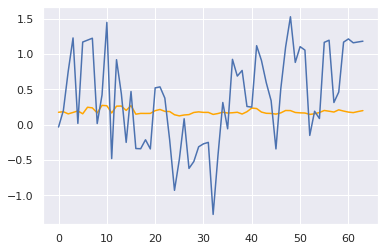

In [140]:
col='TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAACCTGTGGACTG'
sns.lineplot(x = pred_denorm__0001_df.index, y =pred_denorm__0001_df[col], color = 'orange')
sns.lineplot(x = pred_denorm__0001_df.index, y =x_test_clr[col])
plt.ylabel('')

In [134]:
deep_rho_df = calculate_spearman(pred_denorm__0001_df, x_test, 'deep_rho').dropna().reset_index().rename({'index':'target'}, axis=1)
deep_nrmse_df = calculate_nrmse(pred_denorm__0001_df, x_test, 'deep_nrmse').dropna().reset_index().rename({'index':'target'}, axis=1)

inter_dissimilarity_df = inter_dissimilarity(x_test, pred_denorm__0001_df, 'bc')
procrustes_disparity = intra_dissimilarity(x_test, pred_denorm__0001_df)[-1]

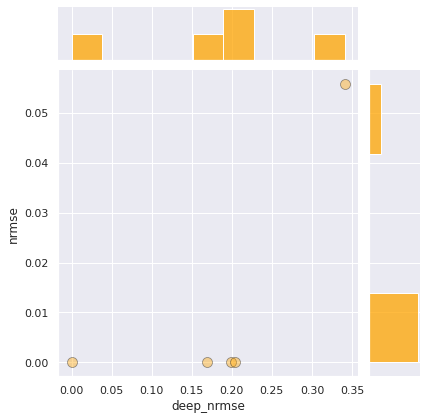

In [137]:
nrmse = pd.merge(deep_nrmse_df, nrmse_df, on=['target'])
nrmse = nrmse[nrmse['deep_nrmse'] < 0.9]

kwargs = {'s':100, 'alpha':.4, 'edgecolor':'black', 'color':'orange'}

sns.jointplot(data = nrmse, x = 'deep_nrmse', y = 'nrmse', **kwargs)

In [ ]:
def model(l1, l2):
    
    l1 = l1
    l2 = l2
    size1 = 64
    size2 = 32
    input_size = normalized_train.shape[1]
    input_data = tf.keras.Input(shape=(input_size,))
   
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(size1, activation='relu', input_dim=input_size))
    model.add(tf.keras.layers.Dense(size2))
    model.add(tf.keras.layers.Dense(input_size))
    
    BrayCurtisLoss = LossBrayCurtis(None, None)
    model.compile(
        loss = LossBrayCurtis,
        optimizer='Adam'
    )
    
    model.run_eagerly = True
    
    return model

seed = 7
np.random.seed(seed)

#build model
model = KerasRegressor(build_fn=model, verbose=0)

batch_size = [8, 16, 32]
epochs = [40]
l1 = [1e-1, 1e-2, 1e-3]
l2 = [1e-1, 1e-2, 1e-3]

param_grid = dict(
    batch_size=batch_size,
    epochs=epochs,
    l1 = l1,
    l2 = l2)


cv = RepeatedKFold(n_repeats=2, n_splits=3, random_state=1)

grid = GridSearchCV(estimator=model,
                    cv=cv,
                    param_grid=param_grid,
                    verbose=1
                   )

grid_result = grid.fit(normalized_train[:-1], normalized_train[1:])
